In [1]:
import pandas as pd
import numpy as np
import os
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
os.chdir(os.path.dirname(os.getcwd()))

In [3]:
columns = ['Date', 'Position_x', 'Position_y', 'Position_z']
df = pd.DataFrame(columns=columns)

with open('RawData/horizons_results_30_years.csv') as f:
    f.readline()
    for line in f:
        line = line.strip().split(',')

        date = line[0]
        position = np.array(list(map(np.float128, line[1:4])))
        new_row = pd.DataFrame([[date, *position]], columns=columns)
        df = pd.concat([df, new_row], ignore_index=True)


/tmp/ipykernel_432867/3046378181.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


In [4]:
#crop df from datetime.datetime(2021, 7, 17, 0, 0) to datetime.datetime(2022, 2, 27, 0, 0)
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'] >= '2021-07-17') & (df['Date'] < '2022-02-27')]
df = df.reset_index(drop=True)
df.head()

,Date,Position_x,Position_y,Position_z
0,2021-07-17,-1.066699e+08,-1.458516e+07,5.939509e+06
1,2021-07-18,-1.060891e+08,-1.755816e+07,5.854842e+06
2,2021-07-19,-1.054376e+08,-2.047769e+07,5.768427e+06
3,2021-07-20,-1.047254e+08,-2.334597e+07,5.681332e+06
4,2021-07-21,-1.039609e+08,-2.616742e+07,5.594390e+06


In [5]:
#interpolation
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

#Convert time to number of days since the first date
time = (df['Date'] - df['Date'].iloc[0]).dt.days.reset_index(drop=True)

In [6]:
target_coordinates = np.empty((0, 3))

with open('RawData/horizons_results_target.csv') as f:
    for line in f:
        line = line.strip().split(',')
        position = np.array(list(map(np.float128, line)))
        target_coordinates = np.vstack((target_coordinates, position))

target_coordinates = target_coordinates[10:235] #Next revolution for Venus

In [7]:
x_interpolator = interpolate.interp1d(time.to_numpy(), df['Position_x'], kind='cubic', fill_value='extrapolate')
y_interpolator = interpolate.interp1d(time.to_numpy(), df['Position_y'], kind='cubic', fill_value='extrapolate')
z_interpolator = interpolate.interp1d(time.to_numpy(), df['Position_z'], kind='cubic', fill_value='extrapolate')

In [8]:
prediction_time = np.arange(0, 225, 1)
x_prediction = x_interpolator(prediction_time)
y_prediction = y_interpolator(prediction_time)
z_prediction = z_interpolator(prediction_time)

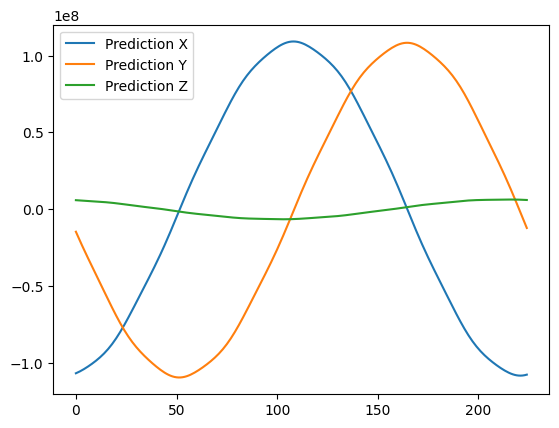

In [9]:
plt.plot(x_prediction[:], label='Prediction X')
plt.plot(y_prediction[:], label='Prediction Y')
plt.plot(z_prediction[:], label='Prediction Z')
plt.legend()
plt.show()

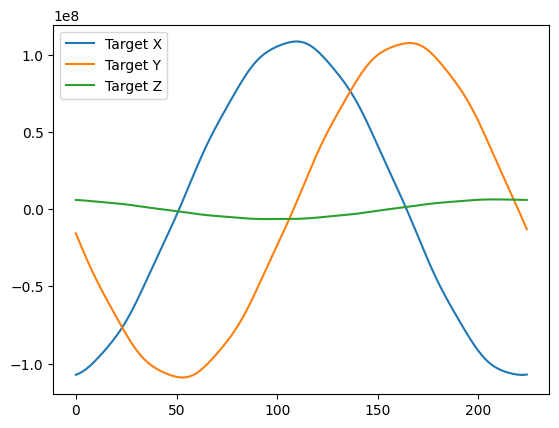

In [10]:
plt.plot(target_coordinates[:,0], label='Target X')
plt.plot(target_coordinates[:,1], label='Target Y')
plt.plot(target_coordinates[:,2], label='Target Z')
plt.legend()
plt.show()

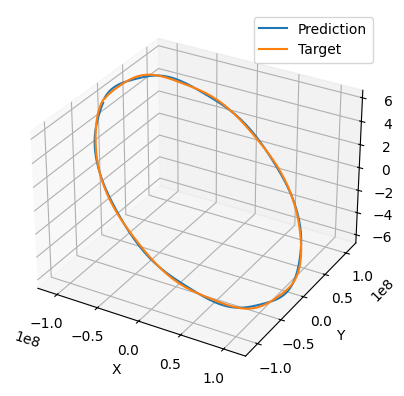

In [11]:
#plot results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_prediction[1:], y_prediction[1:], z_prediction[1:], label='Prediction')
ax.plot(target_coordinates[:, 0], target_coordinates[:, 1], target_coordinates[:, 2], label='Target')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

In [12]:
with open('Results/intepolated_position.txt', 'w') as f:
    for i in range(len(x_prediction)):
        f.write("{:.20f},{:.20f},{:.20f}\n".format(x_prediction[i], y_prediction[i], z_prediction[i]))